In [2]:
import pyadq
from typing import List
import numpy as np
import cupyx
import cupy
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib widget

In [7]:
#basic adq32 example
#!/usr/bin/env python3
# Copyright 2022 Teledyne Signal Processing Devices Sweden AB
"""
 Example illustrating the data acquisition for a ADQ3 series digitizer. The
 example will list the available devices and acquire data from the first
 device.
"""



# Record length in samples
RECORD_LENGTH = 16320*2**10
# Number of records to collect per channel
NOF_RECORDS = 1
# Periodic event generator frequency in Hz
#PERIODIC_EVENT_GENERATOR_FREQUENCY = 2.5e9/RECORD_LENGTH 
#PERIODIC_EVENT_GENERATOR_FREQUENCY = 10000

RECORD_BUFFER_LENGTH = 16320*2**6 #not sure why it likes this size

SIZEOF_INT16 = 2
NOF_RECORDS_PER_BUFFER = 1
NOF_BUFFERS = 2*2

nof_chan = 1


# Create the control unit
acu: pyadq.ADQControlUnit = pyadq.ADQControlUnit()

# Enable trace logging
acu.ADQControlUnit_EnableErrorTrace(pyadq.LOG_LEVEL_INFO, ".")

# List the available devices
device_list: List[pyadq.ADQInfoListEntry] = acu.ListDevices()

print(f"Found {len(device_list)} device(s)")

# Ensure that at least one device is available
assert device_list

# Set up the first available device
device_to_open = 0
dev: pyadq.ADQ = acu.SetupDevice(device_to_open)

print(f"Setting up data collection for: {dev}")

# Initialize the parameters with default values
parameters: pyadq.ADQParameters = dev.InitializeParameters(pyadq.ADQ_PARAMETER_ID_TOP)

# Set up data collection for all channels
for acq_param in parameters.acquisition.channel[0 : nof_chan]:
    acq_param.record_length = RECORD_LENGTH
    acq_param.nof_records = pyadq.ADQ_INFINITE_NOF_RECORDS
    acq_param.trigger_edge = pyadq.ADQ_EDGE_RISING
    acq_param.trigger_source = pyadq.ADQ_EVENT_SOURCE_PERIODIC

for test_param in parameters.test_pattern.channel[0:nof_chan]:
    #test_param.source = pyadq.ADQ_TEST_PATTERN_SOURCE_TRIANGLE
    test_param.source = pyadq.ADQ_TEST_PATTERN_SOURCE_DISABLE

# Configure data transfer parameters for all channels
for transfer_param in parameters.transfer.channel[0 : nof_chan]:
    transfer_param.record_size = SIZEOF_INT16 * RECORD_LENGTH
    transfer_param.record_length_infinite_enabled = 0
    transfer_param.record_buffer_size = (
        RECORD_BUFFER_LENGTH *SIZEOF_INT16
    )
    # Enable metadata (record headers)
    transfer_param.metadata_enabled = 1
    transfer_param.metadata_buffer_size = (
        NOF_RECORDS_PER_BUFFER * pyadq.SIZEOF_ADQ_GEN4_HEADER
    )
    #transfer_param.nof_buffers = pyadq.ADQ_MAX_NOF_BUFFERS
    transfer_param.nof_buffers = NOF_BUFFERS

#enable incomplete records
    for readout_param in parameters.readout.channel[0:nof_chan]:
        readout_param.incomplete_records_enabled = 1


# Configure the periodic event generator
#parameters.event_source.periodic.frequency = PERIODIC_EVENT_GENERATOR_FREQUENCY
parameters.event_source.periodic.period = int(RECORD_BUFFER_LENGTH/100)
#parameters.event_source.periodic.high = 0
#parameters.event_source.periodic.low = 0

# Set parameters
dev.SetParameters(parameters)

# Start the data acquisition
print("Starting data acquisition")
result = dev.ADQ_StartDataAcquisition()
if result != pyadq.ADQ_EOK:
    raise Exception(
        f"ADQ_StartDataAcquisition failed with error code {result}. See log file."
    )

record_count = 0
#records_to_collect = NOF_RECORDS * nof_chan
records_to_collect = RECORD_LENGTH//RECORD_BUFFER_LENGTH

avg = np.zeros(RECORD_LENGTH//2)
averages = 1
plt.close('all')
data = np.zeros((RECORD_BUFFER_LENGTH*records_to_collect))
timestamp = 0
try:
    ti = datetime.datetime.now()
    for i in range(averages):
        record_count = 0
        time.sleep(0)
        print(i)
        
        while record_count < records_to_collect:
            # Wait for a record buffer on any channel with 1000 ms timeout
            record_buffer = dev.WaitForRecordBuffer(pyadq.ADQ_ANY_CHANNEL, 1000)

            if 0:
                print(record_count)
                print('period', record_buffer.header.sampling_period)
                # Print some header information
                print(
                    #f"S/N: {record_buffer.header.serial_number}, "
                    #f"channel {record_buffer.header.channel}"
                )
                print('time unit', record_buffer.header.time_unit)
                print(f"\tTimeStamp delta: {np.log2(record_buffer.header.timestamp - timestamp)}")
                timestamp = record_buffer.header.timestamp
                print(f"\tRecord number: {record_buffer.header.record_number}")
            
                #print(f"\tRecord length: {record_buffer.header.record_length}")
                #print(f"\tData: {record_buffer.data}")
                #print(f"\tN counts clipping: {(record_buffer.data==2**15).sum() + (record_buffer.data==-2**15).sum()}")
            if 0:
                plt.figure()
                plt.plot(record_buffer.data)
                plt.show()

            data[
                record_count*RECORD_BUFFER_LENGTH:(record_count+1)*RECORD_BUFFER_LENGTH] = record_buffer.data
            record_count += 1

            #average FFTs
            if 1: 
                data_gpu = cupy.array(data)

                fft_gpu = np.abs(cupyx.scipy.fft.fft(data_gpu)[0:(RECORD_LENGTH//2)])
                fft = fft_gpu.get()
                fft_mW = fft**2 * 2**-34*2/(50*RECORD_LENGTH**2)*1000
                avg += fft_mW
except Exception as e:
    dev.ADQ_StopDataAcquisition()
    raise e

print("Collected ", record_count, "Buffers")
print("took", datetime.datetime.now() - ti)
print("expected to take:", RECORD_LENGTH/2.5e9*averages, "seconds")
if 0: #time domain ADC counts
    plt.figure()
    plt.title('Time Domain')
    plt.plot(record_buffer.data)
    plt.xlabel('Samples')
    plt.ylabel('Adc counts')
    plt.show()

if 0: #time domain mV
    plt.figure()
    plt.title('Time Domain')
    plt.plot(record_buffer.data/2**16 * 500)
    plt.xlabel('Samples')
    plt.ylabel('miliVolts')
    plt.show()

if 0:
    avg/=(record_count/2)
    plt.figure()
    plt.title('FFT %i averages' %(record_count//2))
    #avg = avg**2 * 2**-34*2/(50*RECORD_LENGTH**2)*1000
    plt.plot(np.linspace(0,1.25,RECORD_LENGTH//2)[1:],10*np.log10(avg[1:]))
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Power (dBm)')
    plt.show()

# Stop the data acquisition
print("Stopping data acquisition")
result = dev.ADQ_StopDataAcquisition()
if result not in [pyadq.ADQ_EOK, pyadq.ADQ_EINTERRUPTED]:
    raise Exception(
        f"ADQ_StartDataAcquisition failed with error code {result}. See log file."
    )



Found 1 device(s)
Setting up data collection for: <ADQ S/N: SPD-10702>
Starting data acquisition
0
Collected  16 Buffers
took 0:00:01.258188
expected to take: 0.006684672 seconds
Stopping data acquisition


NameError: name 'avgTemp' is not defined

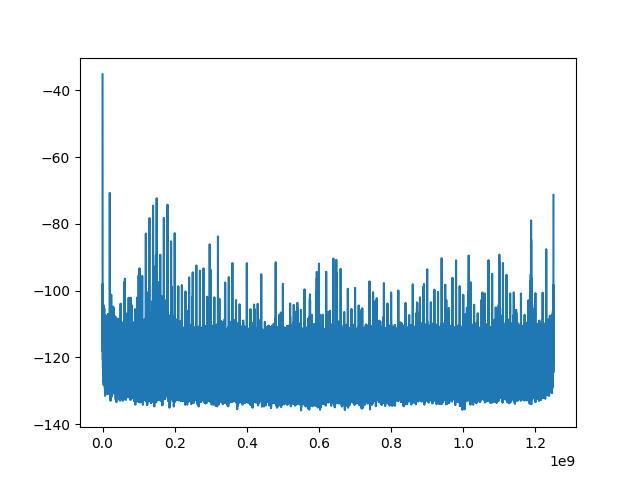

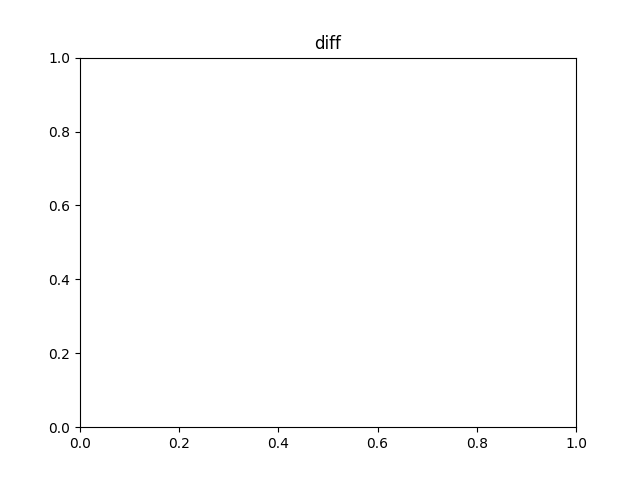

In [8]:
plt.figure()
plt.plot(np.linspace(0,1.25e9,len(avg)),10*np.log10((avg)/averages))

#avg temp defined below, super hacky
plt.figure()
plt.title('diff')
plt.plot(np.linspace(0,1.25e9,len(avg)),(avg-avgTemp)/averages)

In [261]:
avgTemp = avg

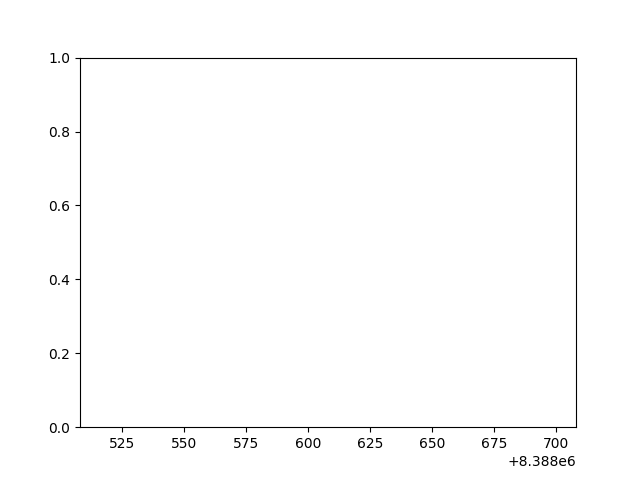

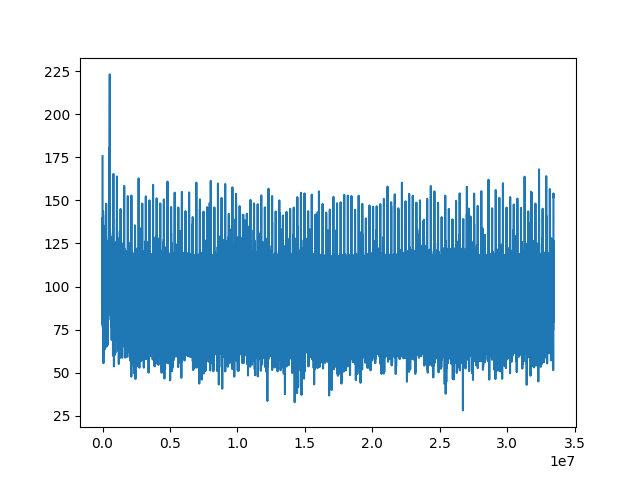

In [16]:
plt.close('all')
plt.figure()
#plt.plot(np.append(data[:,0], data[:,1]))
#plt.plot(data.T.reshape((RECORD_LENGTH//10*records_to_collect)))
plt.xlim(4*2**21 -100, 4*2**21+100)

plt.figure()
plt.plot(10*np.log10((np.abs(np.fft.fft(data.T.reshape(RECORD_LENGTH)))**2)[0:RECORD_LENGTH//2]))

In [59]:
np.log2(data.T.reshape((RECORD_LENGTH*records_to_collect)).shape)

array([25.])

In [106]:
print(data.shape)

print(np.log2(RECORD_LENGTH*records_to_collect))
print(np.log2(data.reshape((RECORD_LENGTH*records_to_collect)).shape))

(2097152, 16)
25.0
[25.]


In [223]:
import cupy as cp
import datetime
import numpy as np
import cupyx
import time 
from cupyx.profiler import benchmark

size = 2**24
record_buffer = 1
arr_cpu = np.random.random((size, record_buffer))
arr_gpu = cp.empty((size, record_buffer))
fft_buffer = cp.empty(size//2) 

gpu_3090 = cp.cuda.Device(0)
gpu_P4000 = cp.cuda.Device(1)

def gpuStuff(arr_cpu, fft_buffer, dev):
    with dev:
        arr_gpu = cp.asarray(arr_cpu)
        ti = datetime.datetime.now()
        fft_buffer += cp.abs(cupyx.scipy.fft.fft(arr_gpu, axis=0)[0:(size//2),:].sum(axis=1))
        #fft_cpu = arr_gpu.get()
        print(datetime.datetime.now() - ti)

In [224]:
#%timeit -n 10 
gpuStuff(arr_cpu, fft_buffer, gpu_P4000)



ValueError: The device where the array resides (0) is different from the current device (1). Peer access is unavailable between these devices.

In [233]:
gpu_3090.mem_info[0]/1e9

21.11995904

In [174]:
test_data = np.random.random((size, 128))
print(test_data.size/1e9)

KeyboardInterrupt: 

In [5]:
cpu_buffer = np.empty(size, 32)
for i in range(32):
    cpu_buffer[:, i] = test_data[:, i]


0.536870912

In [232]:
arr_gpu = None
fft_buffer = None
mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()
mempool.free_all_blocks()
pinned_mempool.free_all_blocks()

In [26]:
from cupyx.profiler import benchmark

def my_func(a):
    return cp.sqrt(cp.sum(a**2, axis=-1))

a = cp.random.random((256, 2**18))
print(benchmark(my_func, (a,), n_repeat=200, n_warmup=5))  

my_func             :    CPU:   64.609 us   +/- 6.016 (min:   57.839 / max:   90.399) us     GPU-0:22802.546 us   +/-8846.032 (min:20512.768 / max:91647.964) us


In [161]:
dev.ADQ_ContinuousStreamingSetup(0)

0

In [109]:
mem = cp.cuda.pinned_memory.alloc_pinned_memory(2**4)
memGpu = cp.cuda.Memory
memGpu.device_id = 1


TypeError: can't set attributes of built-in/extension type 'cupy.cuda.memory.Memory'